## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as m
from torch.utils.data import DataLoader
from transforms import *
from torchvision.transforms import Compose
from torchsummary import summary
from random_caption_dataset import RandomCaptionDataset
from text_preprocessing import *
from inference import *

print(f'PyTorch version: {torch.__version__}')
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device='cpu'

PyTorch version: 1.7.1
GPU found :)


In [2]:
IMAGE_SIZE = 224
EMBEDDING_SIZE = 512
CONTEXT_SIZE = 4
train_annotations_file = './flickr8k/annotations/annotations_image_id_train.csv'
test_annotations_file = './flickr8k/annotations/annotations_image_id_test.csv'

## Datas section

In [3]:
# Init text preprocessing class
tp = TextPreprocessor(train_annotations_file, sep=';')

In [72]:
transforms = Compose([Rescale(256), 
                      RandomCrop(IMAGE_SIZE), 
                      ToTensor(), Normalize(),
                      OneHotEncode(tp)])

train_random_dataset = RandomCaptionDataset('./flickr8k/images/train/', train_annotations_file, transform=transforms)

print(f'Random dataset size: {len(train_random_dataset)}')

Random dataset size: 6000
(15, 8255)
(11, 8255)


In [5]:
batch_size = 1

# Build data loader
train_random_loader = DataLoader(train_random_dataset, batch_size=batch_size)

## Model section

In [6]:
# retrieve pretrained model for features extraction
base_cnn = m.resnet18(pretrained=True)
#base_cnn

In [7]:
# Keep only the feature extraction layers of the model
cnn = nn.Sequential(*(list(base_cnn.children())[:-1])).to(device, dtype=torch.float)
#summary(cnn, (3, IMAGE_SIZE, IMAGE_SIZE))

## Build LSTM + Embedding

In [8]:
vocab_size = tp.vocab_size
print(vocab_size)

# RNN with LSTM of  layer
class LSTMCaptioning(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMCaptioning, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.hidden2out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, previous_state):
         
        # Get hidden states for each t (out) , and latest one (h = (ht, ct))
        lstm_out, (hn, cn) = self.lstm(x, previous_state)
        
        # Convert output of rnn to output targeted size
        out = self.hidden2out(lstm_out.view(1, -1))
        
        # Compute probability distribution over all words for this t
        pt = F.log_softmax(out, dim=1)
                           
        return (hn, cn), pt

# Need to copy class here to load trained Ngram model    
class NGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGram, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        
        embeds = self.embeddings(inputs).view(len(inputs), -1)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        
        return log_probs


# Not trained embedding layer to encode words to hidden space
#embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE).to(device)

# Load model for evaluation
ngram_model = NGram(vocab_size, EMBEDDING_SIZE, CONTEXT_SIZE)
ngram_model.load_state_dict(torch.load('./models/ngram_512_v1'))

embedding = list(ngram_model.children())[0].to(device)
embedding

8255


Embedding(8255, 512)

## Train model

In [9]:
input_size = EMBEDDING_SIZE
hidden_size = 256

model = LSTMCaptioning(input_size, hidden_size, vocab_size).to(device, dtype=torch.float)

In [20]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epoch = 10
step_count = len(train_random_loader)
loss_function = nn.NLLLoss()

# Random init the lstm state
h0 = torch.rand((1, batch_size, hidden_size)).to(device, dtype=torch.float)
c0 = torch.rand((1, batch_size, hidden_size)).to(device, dtype=torch.float)


for epoch in range(num_epoch):
    for i, sample in enumerate(train_random_loader):
        
        image = sample['image'].to(device, dtype=torch.float)
        caption = sample['caption'].to(device, dtype=torch.long)
        
        # Reset grad
        model.zero_grad()
        
        # Get the input image embedding 
        image_embedding = cnn(image).view(-1, batch_size, EMBEDDING_SIZE)
        
        
        # Forward pass for t=-1: image
        (hn, cn), probs = model(image_embedding, (h0, c0))
        
        del image_embedding
        del image
        
        target = tp.target_from_vect(caption[:, 0]).to(device)
        
        # Compute loss for 1st word prediction
        loss = loss_function(probs, target)
        
        # Forward pass for t>=0: n - 1 first words of the sentence
        for j, word in enumerate(caption[:, :-1][0]):

            
            # Get index of the word in embedding matrix
            idxs = torch.argmax(word)
            
            # Encode word to hidden space
            word_embedding = embedding(idxs).view(1, batch_size, EMBEDDING_SIZE)
            
            # Feed the rnn
            (hn, cn), probs = model(word_embedding, (hn, cn))
            
            target = tp.target_from_vect(caption[:, j+1]).to(device)
            
            # Add current word's loss
            loss += loss_function(probs, target)

        
        # Compute loss and backprop
        loss.backward()
        optimizer.step()
        
        
        # Debug
        if((i+1) % (step_count/10) == 0):
            print(
                        f"Epoch [{epoch + 1}/{num_epoch}]"
                        f", step [{i + 1}/{step_count}]"
                        f", loss: {loss.item():.4f}"
                    )
        

Epoch [1/10], step [600/6000], loss: 0.6235
Epoch [1/10], step [1200/6000], loss: 1.7184
Epoch [1/10], step [1800/6000], loss: 0.2848
Epoch [1/10], step [2400/6000], loss: 0.3135
Epoch [1/10], step [3000/6000], loss: 0.3978
Epoch [1/10], step [3600/6000], loss: 2.5088
Epoch [1/10], step [4200/6000], loss: 2.0476
Epoch [1/10], step [4800/6000], loss: 15.6183
Epoch [1/10], step [5400/6000], loss: 0.6578
Epoch [1/10], step [6000/6000], loss: 5.4051
Epoch [2/10], step [600/6000], loss: 0.6132
Epoch [2/10], step [1200/6000], loss: 2.0885
Epoch [2/10], step [1800/6000], loss: 0.4388
Epoch [2/10], step [2400/6000], loss: 0.3691
Epoch [2/10], step [3000/6000], loss: 0.3269
Epoch [2/10], step [3600/6000], loss: 2.7678
Epoch [2/10], step [4200/6000], loss: 1.9857
Epoch [2/10], step [4800/6000], loss: 2.8766
Epoch [2/10], step [5400/6000], loss: 0.6330
Epoch [2/10], step [6000/6000], loss: 5.4582
Epoch [3/10], step [600/6000], loss: 0.5637
Epoch [3/10], step [1200/6000], loss: 1.7088
Epoch [3/10]

In [10]:
# Save model 
torch.save(model.state_dict(), './models/model_v2_random')

## Test model performances

In [10]:
# Load model for evaluation
trained_model = LSTMCaptioning(input_size, hidden_size, vocab_size)
trained_model.load_state_dict(torch.load('./models/model_v2_random'))
trained_model.to(device)

LSTMCaptioning(
  (lstm): LSTM(512, 256)
  (hidden2out): Linear(in_features=256, out_features=8255, bias=True)
)

In [31]:
# Create test loaders for datasets

# Only preprocess images
test_transforms = Compose([Rescale(256), 
                      RandomCrop(IMAGE_SIZE), 
                      ToTensor(), 
                      Normalize()])

test_random_dataset_unformatted = RandomCaptionDataset('./flickr8k/images/test', test_annotations_file)
train_random_dataset_unformatted = RandomCaptionDataset('./flickr8k/images/train', train_annotations_file)


test_random_dataset = RandomCaptionDataset('./flickr8k/images/test', test_annotations_file, transform=test_transforms)

test_random_loader = DataLoader(test_random_dataset, batch_size=batch_size)

In [68]:
image = train_random_dataset[5]['image'].view(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device, dtype=torch.float)
caption = sampling(cnn, embedding, trained_model, image, tp, EMBEDDING_SIZE, hidden_size, max_length=20)

In [69]:
print(caption)

bareback sunrise pats tending logos cows sledder well-dressed go-cart see tiretracks lack faced practicing Dale skateboard fence engage Lady glide glide


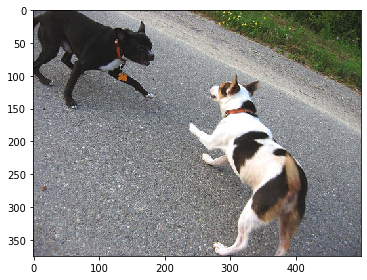

In [67]:
from skimage import io
image = train_random_dataset_unformatted[5]['image']
io.imshow(image)